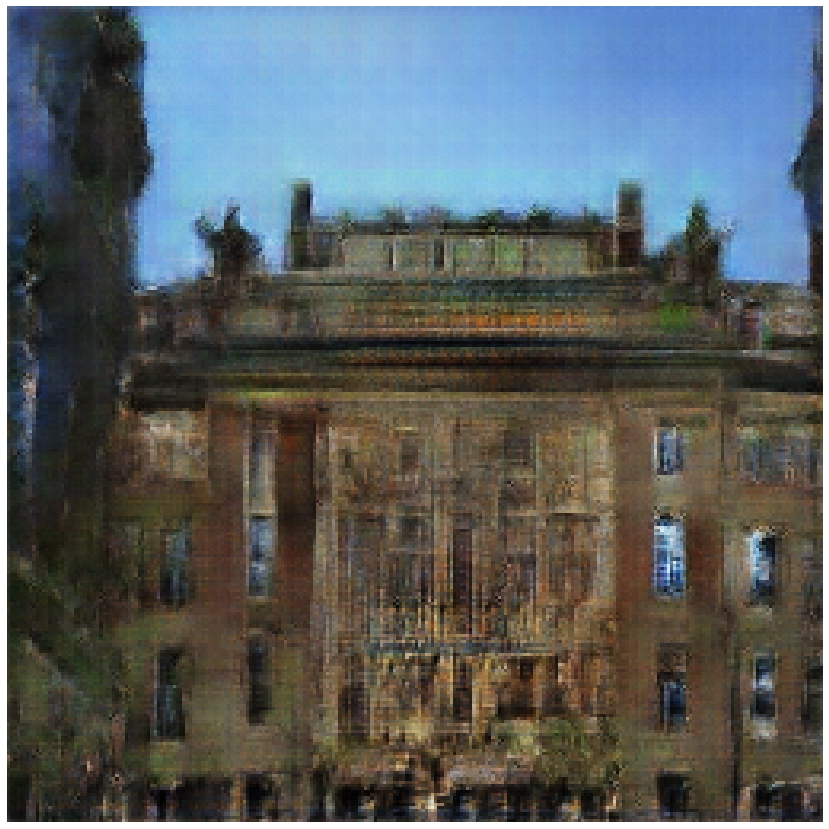

In [18]:
import numpy as np
import os
import tensorflow as tf
from tkinter import *
from PIL import Image, ImageDraw, ImageTk
import PIL
import random
import time
#from src.gui_functions import *
#from src.recognition import *
from tkinter import messagebox as mb
from tkinter import filedialog
from keras.models import load_model
from src.discriminator_functions import Discriminator, discriminator_loss
from src.generator_functions import downsample, upsample, Generator, generator_loss
from src.Image_processing_functions import load_image_train, load_image_test, get_concat_h
from src.Image_processing_functions import BUFFER_SIZE, BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from src.training_and_generate_images_functions import generate_images
import cv2
import pyautogui
import glob
#def main():

#Load model:
#Maybe I have to move this to the main.py...
#model = load_model('inputs/images/example_photo_training.jpg') #model_sketch_extended_v5

master = Tk()
master.geometry('1000x520')
master.title('Image Inpainting for Urban Buildings')
master.resizable(0, 0)
#Shut down on escape
master.bind('<Escape>', lambda e: exit(master))

#Bckground picture canvas:
cv_back = Canvas(master)
img = ImageTk.PhotoImage(Image.open("inputs/images/background.jpg"))
cv_back.create_image(0,-100, anchor=NW, image=img)
cv_back.place(x=0, y=0, relwidth=1.5, relheight=1)#grid(row=0, column=0, columnspan=3, rowspan=5)

#Create canvas images:
cv = Canvas(master, width=700, height=400, borderwidth=2, bg='#dedad9')
cv.grid(row=1, column=1, columnspan=1, rowspan=1)
cv.pack(fill=BOTH)
cv.place(x=150, y=50)
#cv.bind("<B1-Motion>", lambda x: paint(event=x, cv=cv, draw=draw))

#  
image1 = PIL.Image.new("RGB", (700, 400),(255,255,255))
draw = ImageDraw.Draw(image1)

folder_path = StringVar()

def browse_button():
    # Allow user to select a directory and store it in global var
    # called folder_path
    global folder_path
    filename = filedialog.askopenfilename()
    folder_path.set(filename)
    return loadImage(filename, cv)


def loadImage(filename, cv):
    img = Image.open(filename)
    filename = ImageTk.PhotoImage(img)
    #canvas = Canvas(cv,height=400,width=700)
    cv.image = filename  # <--- keep reference of your image
    x0 = img.size[0]/2
    y0 = img.size[1]/2
    cv.create_image(x0,y0,anchor='center',image=filename)
    cv.pack()
    cv.place(x=150, y=50)
    return cv

    
def paint_black(event, cv, draw):
    # python_green = "#476042"
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)  
    cv.create_oval(x1, y1, x2, y2, fill='black', width=2)
    draw.line([x1, y1, x2, y2],fill='black',width=2)

def paint_white(event, cv, draw):
    # python_green = "#476042"
    x1, y1 = (event.x - 4), (event.y - 4)
    x2, y2 = (event.x + 4), (event.y + 4)  
    cv.create_oval(x1, y1, x2, y2, fill='white', width=0)
    draw.line([x1, y1, x2, y2],fill='white',width=0)    

    
def drawing():
    cv.bind("<B1-Motion>", lambda x: paint_black(event=x, cv=cv, draw=ImageDraw.Draw(image1)))

    
def eraser():
    cv.bind("<B1-Motion>", lambda x: paint_white(event=x, cv=cv, draw=ImageDraw.Draw(image1)))

    
def reset():
    cv.delete('all')
    
    
def close_window():
    master.destroy()
    
def save_button():
    # Allow user to select a directory and store it in global var
    # called folder_path
    global folder_path
    dlg = filedialog.asksaveasfilename(title="Select file",
                                       confirmoverwrite=False,
                                      filetypes=(
        ('JPEG', ('*.jpg', '*.jpeg', '*.jpe')), ('PNG', '*.png'), ('BMP', ('*.bmp', '*.jdib')), ('GIF', '*.gif')))
    fname = dlg
    image1.save(fname)

    
def generate_images_tkinter(model, test_input, tar):
    '''
    Write a function to plot some images during training.
    Pass images from the test dataset to the generator. The generator will then translate the input image into the output. 
    Last step is to plot the predictions.
    Note: The training=True is intentional here since we want the batch statistics while running the model on the test dataset. 
    If we use training=False, we will get the accumulated statistics learned from the training dataset (which we don't want).
    model is the generator.    
    '''
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    plt.imshow(prediction[0] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()


    
import pyautogui

def create_predict_from_tkinter():
    myScreenshot = pyautogui.hotkey('shift', 'printscreen')
    time.sleep(10)

    generator = Generator()
    discriminator = Discriminator()
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    #image1.save('imagenes/disegni/screenshot2.png')
    list_of_files = glob.glob('../../../Pictures/*') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    img = cv2.imread(latest_file)[:,:,::-1] 
    edges = cv2.Canny(img,100,200)
    PIL_image1 = Image.fromarray(np.uint8(img)).convert('RGB')
    PIL_image2 = Image.fromarray(np.uint8(edges)).convert('RGB')
    img_concat = get_concat_h(PIL_image1, PIL_image2)
    img_concat.save('imagenes/output/1.png')
    test_dataset = tf.data.Dataset.list_files('imagenes/output/1.png')
    test_dataset = test_dataset.map(load_image_test)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    for example_input, example_target in test_dataset.take(1):
        generate_images_tkinter(generator, example_input, example_target)

           
        
        
        
button1 = Button(master, text = 'Open Image', fg='white', activebackground="#c4e59a", font='Helvetica 8 bold', padx=25, pady=15, bd=5,bg="#898989", command=browse_button)
button1.place(x = 20, y = 50, width=120, height=25)

button2 = Button(master, text = 'Draw',fg='white', activebackground="#5D836C", font='Helvetica 8 bold', padx=25, pady=15, bd=5,bg="#898989", command=drawing)
button2.place(x = 20, y = 80, width=120, height=25)

button3 = Button(master, text = 'Eraser', fg='white',activebackground="#B0FC38", font='Helvetica 8 bold', padx=25, pady=15, bd=5,bg="#898989", command=eraser)
button3.place(x = 20, y = 110, width=120, height=25)

button4 = Button(master, text = 'Reset', fg='white',activebackground="#64dbc0", font='Helvetica 8 bold', padx=25, pady=15, bd=5,bg="#898989", command=reset)
button4.place(x = 20, y = 140, width=120, height=25)

button5 = Button(master, text = 'Save Image', fg='white',activebackground="#497e1e", font='Helvetica 8 bold', padx=25, pady=15, bd=5,bg="#898989", command=save_button)
button5.place(x = 20, y = 170, width=120, height=25)

button6 = Button(master, text = 'Exit', fg='white',activebackground="#54ca7f", font='Helvetica 8 bold', padx=25, pady=15, bd=5,bg="#898989", command=close_window)
button6.place(x = 20, y = 200, width=120, height=25)

button7 = Button(master, text = 'Create', fg='white',activebackground="#54ca7f", font='Helvetica 8 bold', padx=25, pady=15, bd=5,bg="#898989", command=create_predict_from_tkinter)
button7.place(x = 20, y = 230, width=120, height=225)


master.mainloop()

In [ ]:
myScreenshot = pyautogui.hotkey('ctrl', 'shift', 'prtsc')
#myScreenshot.save('imagenes/disegni/screenshot2.png')


In [ ]:
myScreenshot.save("screen.png")

In [ ]:
import pyscreenshot as ImageGrab

im = ImageGrab.grab()

im.save('imagenes/disegni/screenshot2.png')

im.show()

In [ ]:
screenshot = pyautogui.screenshot()
screenshot.save("screen.png")

In [ ]:
from pyautogui import press
press('ctrl')
press('shift')
press("printscreen")

In [ ]:

myScreenshot = pyautogui.hotkey('shift', 'printscreen')

In [ ]:
from PIL import ImageGrab, Image
img = ImageGrab.grabclipboard()

In [ ]:
print(myScreenshot)

In [ ]:
img = cv2.imread('../../../Pictures/Screenshot from 2020-07-27 14-45-37.png')

In [ ]:
PIL_image = Image.fromarray(np.uint8(img)).convert('RGB')

In [ ]:
print(len(img))

In [ ]:
plt.figure()
plt.imshow(img)

In [ ]:
edges = cv2.Canny(img,100,200)

In [ ]:
PIL_image1 = Image.fromarray(np.uint8(img)).convert('RGB')
PIL_image2 = Image.fromarray(np.uint8(edges)).convert('RGB')
img_concat = get_concat_h(PIL_image1, PIL_image2)
img_concat.save('imagenes/output/1.png')

In [ ]:
plt.figure()
plt.imshow(img_concat)

In [ ]:

def generate_images(model, image):
    '''
    Write a function to plot some images during training.
    Pass images from the test dataset to the generator. The generator will then translate the input image into the output. 
    Last step is to plot the predictions.
    Note: The training=True is intentional here since we want the batch statistics while running the model on the test dataset. 
    If we use training=False, we will get the accumulated statistics learned from the training dataset (which we don't want).
    model is the generator.    
    '''
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
g(generator, img_concat)

In [ ]:
img = cv2.imread('imagenes/de_convertir/FaSyn/FaSyn13/images/1.jpg')[:,:,::-1]

In [ ]:
plt.figure()
plt.imshow(img)

In [ ]:
import glob
list_of_files = glob.glob('../../../Pictures/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

In [ ]:
print(latest_file)